In [1]:
from SPV_utils import *

In [2]:
# folder = "./coordinate_p0=3.80_v0=0.20_pin=0_set_10/"
folder = r"N=400_pin=0\N=400\coordinate_p0=3.80_v0=0.50_pin=0_set_3/"
# folder = r"N=1024_pin=0\N=1024\coordinate_p0=3.80_v0=0.50_pin=0_set_3/"
timestamps, arrays = get_data_from_folder(folder)
init_pos = arrays[100]    #should i take it at zero???

In [3]:
def g_vector(positions, bins=100, range_xy=None):
    """
    Compute 2D vector pair correlation g(r_vec) from Nx2 positions.
    Returns:
        H : 2D histogram (g(r_vec))
        xedges, yedges : bin edges
    """

    pos = np.asarray(positions)
    N = len(pos)

    # all pair displacement vectors
    disp = pos[None, :, :] - pos[:, None, :]
    disp = disp.reshape(-1, 2)   # shape (N*N, 2)

    # Optionally remove self-pairs
    disp = disp[~np.all(disp == 0, axis=1)]

    # histogram range
    if range_xy is None:
        max_range = np.max(np.abs(disp))
        range_xy = [[-max_range, max_range], [-max_range, max_range]]

    # 2D histogram
    H, xedges, yedges = np.histogram2d(disp[:,0], disp[:,1],
                                       bins=bins, range=range_xy)

    # Normalize by expected ideal-gas counts
    area = (xedges[1]-xedges[0]) * (yedges[1]-yedges[0])
    rho = N / ((pos[:,0].max()-pos[:,0].min()) *
               (pos[:,1].max()-pos[:,1].min()))
    H = H / (N * rho * area)

    return H, xedges, yedges


In [4]:
H, xe, ye = g_vector(init_pos)

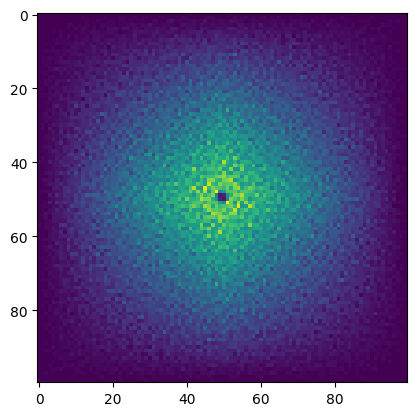

In [5]:
plt.imshow(H)

In [12]:
def g_radial(positions, dr=0.01, r_max=None):
    pos = np.asarray(positions)
    N = len(pos)

    # pair distances
    disp = pos[None,:,:] - pos[:,None,:]
    dist = np.linalg.norm(disp, axis=2).ravel()

    dist = dist[dist > 0]   # remove self-distances

    # max radius
    if r_max is None:
        r_max = dist.max()

    bins = np.arange(0, r_max+dr, dr)
    hist, edges = np.histogram(dist, bins=bins)

    # normalization
    Lx = pos[:,0].max() - pos[:,0].min()
    Ly = pos[:,1].max() - pos[:,1].min()
    area = Lx * Ly
    rho = N / area

    r = 0.5*(edges[:-1] + edges[1:])
    shell_area = 2 * np.pi * r * dr

    g = hist / (N * rho * shell_area)

    return r, g
r, g = g_radial(init_pos, r_max = 10)

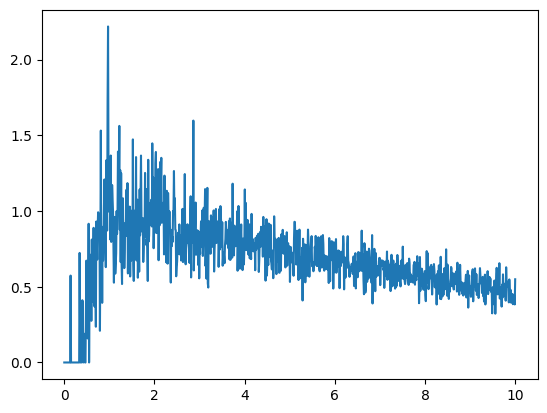

In [13]:
plt.plot(r, g)

In [8]:
r[np.argmax(g)]

np.float64(0.975)

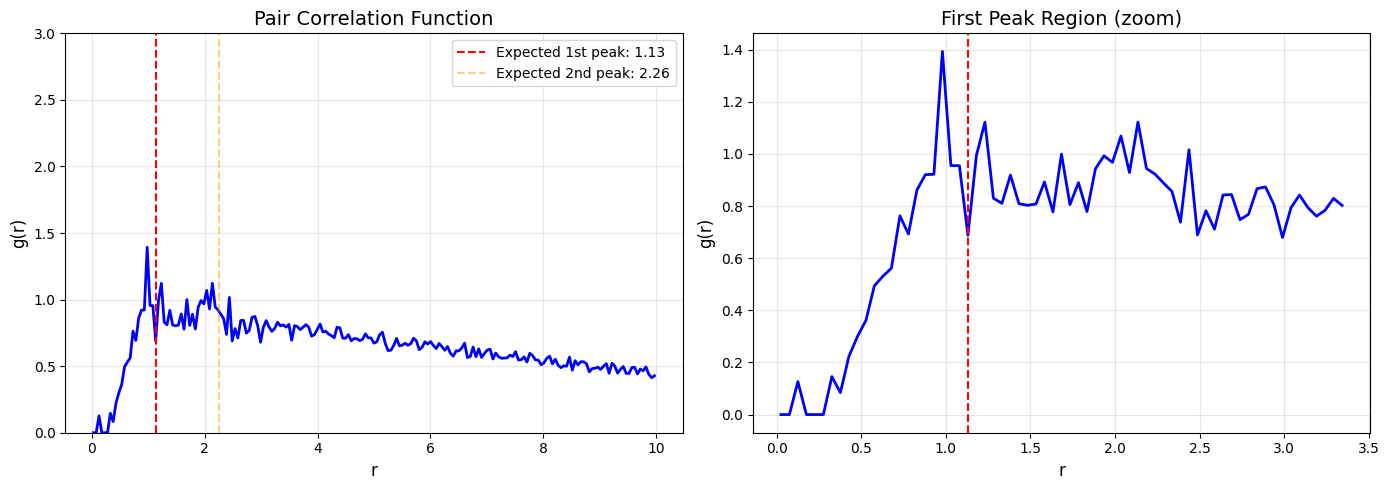


PAIR CORRELATION ANALYSIS
Expected first peak at r ≈ 1.128
Found peak at r = 0.980
Peak height g(r_peak) = 1.393

⚠️  First peak is VERY WEAK (g < 1.5)
   → System has poor spatial order
   → NOT confluent or highly disordered


In [11]:
def compute_and_plot_gr(positions, box_size, A_0):
    """
    Compute pair correlation function g(r)
    """
    from scipy.spatial import distance_matrix
    
    # Compute all pairwise distances
    dists = distance_matrix(positions, positions)
    np.fill_diagonal(dists, np.inf)
    
    # Flatten to get all pair distances
    pair_dists = dists[np.triu_indices_from(dists, k=1)]
    
    # Histogram
    r_max = box_size / 2
    bins = np.linspace(0, r_max, 200)
    hist, bin_edges = np.histogram(pair_dists, bins=bins)
    r = (bin_edges[:-1] + bin_edges[1:]) / 2
    dr = bin_edges[1] - bin_edges[0]
    
    # Normalize to get g(r)
    N = len(positions)
    density = N / box_size**2
    shell_area = 2 * np.pi * r * dr
    expected_count = (N * (N-1) / 2) * (shell_area / box_size**2)
    
    g_r = hist / expected_count
    g_r[expected_count == 0] = 0  # Avoid division by zero
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Panel 1: g(r)
    ax = axes[0]
    ax.plot(r, g_r, 'b-', linewidth=2)
    
    # Mark expected peak positions
    cell_diameter = 2 * np.sqrt(A_0 / np.pi)
    ax.axvline(cell_diameter, color='red', linestyle='--', 
               label=f'Expected 1st peak: {cell_diameter:.2f}')
    ax.axvline(2*cell_diameter, color='orange', linestyle='--', alpha=0.5,
               label=f'Expected 2nd peak: {2*cell_diameter:.2f}')
    
    ax.set_xlabel('r', fontsize=12)
    ax.set_ylabel('g(r)', fontsize=12)
    ax.set_title('Pair Correlation Function', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, max(3, g_r.max()*1.1))
    
    # Panel 2: Zoom on first peak region
    ax = axes[1]
    mask = r < 3 * cell_diameter
    ax.plot(r[mask], g_r[mask], 'b-', linewidth=2)
    ax.axvline(cell_diameter, color='red', linestyle='--')
    ax.set_xlabel('r', fontsize=12)
    ax.set_ylabel('g(r)', fontsize=12)
    ax.set_title('First Peak Region (zoom)', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis
    print("\n" + "="*60)
    print("PAIR CORRELATION ANALYSIS")
    print("="*60)
    
    # Find first peak
    mask_search = (r > 0.5*cell_diameter) & (r < 2*cell_diameter)
    if mask_search.sum() > 0:
        r_search = r[mask_search]
        g_search = g_r[mask_search]
        peak_idx = np.argmax(g_search)
        r_peak = r_search[peak_idx]
        g_peak = g_search[peak_idx]
        
        print(f"Expected first peak at r ≈ {cell_diameter:.3f}")
        print(f"Found peak at r = {r_peak:.3f}")
        print(f"Peak height g(r_peak) = {g_peak:.3f}")
        print()
        
        if g_peak < 1.5:
            print("⚠️  First peak is VERY WEAK (g < 1.5)")
            print("   → System has poor spatial order")
            print("   → NOT confluent or highly disordered")
        elif g_peak > 2.5:
            print("✓ First peak is strong (g > 2.5)")
            print("  → Good spatial correlations")
        else:
            print("? First peak is moderate")
    
    print("="*60)
    
    return r, g_r

# Run analysis
r, g_r = compute_and_plot_gr(init_pos, 20, A_0=1.0)